In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt
from qutip.qip.circuit import Gate
from qutip.qip.circuit import QubitCircuit, Gate
from scipy.optimize import minimize
from scipy.fft import fft, ifft, fftfreq, fftshift


import scipy.constants as cst

import sys
sys.path.append('/Users/sebastien/Documents/Code/QRAM/qutip_sims')

from PulseSequence import PulseSequence
from QSwitch import QSwitch

%matplotlib widget
%config InlineBackend.figure_format = 'svg'

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True


Bad key text.latex.unicode in file /Users/sebastien/.matplotlib/stylelib/paper.mplstyle, line 175 ('text.latex.unicode : True # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key scatter.linewidths in file /Users/sebastien/.matplotlib/stylelib/paper_2.mplstyle, line 632 ('scatter.linewidths: 0.8')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key text.latex.unicode in file /Users/sebastien/.matplotlib/stylelib/slide.mplstyle, line 175 ('text.latex.unicode : True # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/mat

In [2]:
hbar = cst.hbar
h = cst.h
qe = cst.e
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [147]:
qubit_freqs = None
alphas = None


EJs = None
ECs = None


rotating_frame = False


qubit_eg = np.array([4116.60193514429-20,3450.456887958334, 4766.561902541384, 4381.086137747587 + 100])*1e-3
qubit_ef = np.array([3890.5466932677664-20,3349.983151894969, 4576.680453599131,4210.642810651382 + 100])*1e-3

# qubit_eg = np.array([3450.456887958334, 4766.561902541384])*1e-3
# qubit_ef = np.array([3349.983151894969, 4576.680453599131])*1e-3

alphas = (qubit_ef - qubit_eg)

gs = np.zeros((4, 4))
gs[0, 1] = 53.81744103399963e-3
gs[1, 2] = 55.95274071800953e-3
gs[1, 3] = 44.5514225071792e-3
gs[0, 2] = 4.324246873301848e-3
gs[0, 3] = 2.3034231276846207e-3
gs[2, 3] = 6.286079155406997e-3

gs = gs + gs.T

gs = gs + gs.T



In [216]:
cutoffs = [3, 3, 3, 3]
# cutoffs = [4, 4]

# isCavity = [False, False, False, False]
isCavity = [False, False, False]



qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    qubit_freqs=qubit_eg,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas


In [217]:
H_rot = qram.H*0

for i in range(cutoffs[0]):
    for j in range(cutoffs[1]):
            # for l in range(cutoffs[3]):
            # psi_ids = [i, j, k, l]
            psi_ids = [i, j]
            psi = qram.level_nums_to_name(psi_ids)
            psi_i = qram.level_nums_to_name([i,0])
            psi_j = qram.level_nums_to_name([0,j])
            ket = qram.state(psi)
            ket_i = qram.state(psi_i)
            ket_j = qram.state(psi_j)
            wi = ket_i.dag()*qram.H*ket_i/2/np.pi
            wj = ket_j.dag()*qram.H*ket_j/2/np.pi
            H_rot += (wi + wj)*ket*ket.dag()

e_disp, eig_disp = H_rot.eigenstates()

AssertionError: (81, 1) (9, 1)

In [218]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels,rotation='vertical',verticalalignment='top')
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 2), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_test, rho_id=None, title='', cmax=None, savetitle=None, figsize=(15, 15)):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    cutoffs = rho_test.dims[0]
    print(len(cutoffs))

    if len(cutoffs) == 4:
        labels = [f'$|{qram.level_nums_to_name([i, j, k, l])}\\rangle$' for i in range(2) for j in range(2) for k in range(2) for l in range(2)]
    elif len(cutoffs) == 3:
        labels = [f'$|{qram.level_nums_to_name([i, j, k])}\\rangle$' for i in range(2) for j in range(2) for k in range(2)]
    elif len(cutoffs) == 2:
        labels = [f'$|{qram.level_nums_to_name([i, j])}\\rangle$' for i in range(2) for j in range(2)]
    else:
        labels = [f'$|{qram.level_nums_to_name([i])}\\rangle$' for i in range(2)]
    fig, ax = plt.subplots(2, 1, figsize=figsize)


    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_test), np.imag(rho_test), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_test), ax=ax[0], title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_test), ax=ax[1], title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    
    plt.show()

In [239]:
ph_in = -np.pi/2
ph_eg = 0
amp = 0.2

In [247]:
seq = PulseSequence(start_time=0)

# if qb_start == 0:
#     wd = qram.get_wd('eg', 'gf', amp=amp, drive_qubit=1, verbose=True)
#     eg_fg = qram.add_sequential_pi_pulse(seq, 'eg', 'gf', amp=amp, drive_qubit=1, phase=ph_eg, t_pulse = 1000, wd=wd)
#     psi0 = qram.state('eg')
# else:
    # wd = qram.get_wd('fg', 'ge', amp=amp, drive_qubit=0, verbose=True)
    # eg_fg = qram.add_sequential_pi_pulse(seq, 'fg', 'ge', amp=amp, drive_qubit=0, phase=ph_eg, t_pulse = 1000, wd=wd)
    # psi0 = qram.state('fg')


state_1 = 'gegg'
state_2 = 'ggfg'
drive_qubit = 2

wd = qram.get_wd(state_1, state_2, amp=amp, drive_qubit=drive_qubit, verbose=True)
tp = qram.get_Tpi(wd=wd, state1=state_1, state2=state_2, amp=amp, drive_qubit=drive_qubit, verbose=True)
eg_ge = qram.add_sequential_pi_pulse(seq, state_1, state_2, amp=amp, drive_qubit=drive_qubit, phase=ph_eg, wd=wd, t_pulse = tp)
# psi0 = qram.state('eg')

1
One photon transition
Two qubit gate
infidelity:  0.4557351773996141
infidelity:  0.4557351845609462
infidelity:  0.5223277850815438
infidelity:  0.5223277835388801
infidelity:  0.42953098837054793
infidelity:  0.4295309769810325
infidelity:  0.3016698199675185
infidelity:  0.30166986766541626
infidelity:  0.3924126577272542
infidelity:  0.3924126379067501
infidelity:  0.1017764155940426
infidelity:  0.10177646881133295
infidelity:  0.08997361922624036
infidelity:  0.08997358451702464
infidelity:  0.4379103224378119
infidelity:  0.437910332750129
infidelity:  0.10812813130571575
infidelity:  0.10812819080546021
infidelity:  0.08274584198736235
infidelity:  0.0827458406087358
infidelity:  0.08273526486726168
infidelity:  0.0827352649401023
infidelity:  0.08273523530415638
infidelity:  0.08273523530413907
first step:  0.9172647646958436
wd 5.939526987409693


In [248]:
wd/2/np.pi

5.939526987409693

[5.939526987409693] (GHz)
[141.22244636] (ns)
total pulse length 141.22244636435292 ns
[0.00000000e+00 3.02505394e-02 6.05010788e-02 ... 1.51161945e+02
 1.51192196e+02 1.51222446e+02]


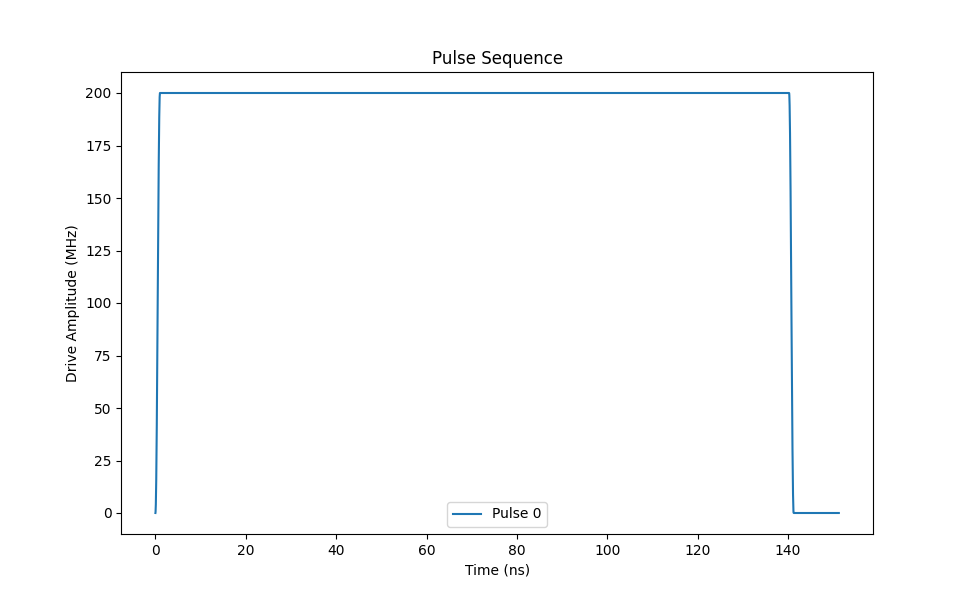

In [249]:
envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_lens = seq.get_pulse_lengths()
pulse_freq = seq.get_pulse_freqs()
print(seq.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')

times = np.linspace(0, sum(seq.get_pulse_lengths())  + 10, 5000)
flat_times = np.array(times).flatten()

fig, ax = plt.subplots(1, 1)

print(flat_times)
for i in range(len(envelope_seq)):
    ax.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Drive Amplitude (MHz)')
# plt.xlim(0, 200)
ax.set_title('Pulse Sequence')
ax.legend()




In [250]:
psi0 = qram.state(state_1)
result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=5000)

if rotating_frame:
    print('Rotating frame')
    # result_rot = [0*result[i_t] for i_t in range(len(times))]
    # evals, evecs = qram.esys

    # for i_t, t in enumerate(tqdm(times)):
    #     for eval, evec in zip(evals, evecs):
    #         result_rot[i_t] += np.exp(1j*eval*t) * evec.overlap(result[i_t]) * evec
else:
    result_rot = result



10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.24s. Est. time left: 00:00:00:00
30.0%. Run time:   0.36s. Est. time left: 00:00:00:00
40.0%. Run time:   0.48s. Est. time left: 00:00:00:00
50.0%. Run time:   0.61s. Est. time left: 00:00:00:00
60.0%. Run time:   0.73s. Est. time left: 00:00:00:00
70.0%. Run time:   0.86s. Est. time left: 00:00:00:00
80.0%. Run time:   0.99s. Est. time left: 00:00:00:00
90.0%. Run time:   1.12s. Est. time left: 00:00:00:00
Total run time:   1.24s


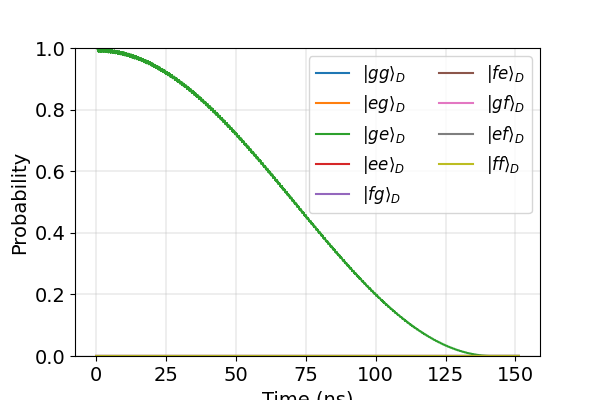

In [251]:
eg = qram.state('eggg')
gg = qram.state('gggg')
ge = qram.state('gegg')
ee = qram.state('eegg')
fg = qram.state('fggg')
fe = qram.state('fegg')
gf = qram.state('gfgg')
ef = qram.state('efgg')
ff = qram.state('ffgg')



prob_eg = [np.abs(eg.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_gg = [np.abs(gg.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_ge = [np.abs(ge.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_ee = [np.abs(ee.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_fg = [np.abs(fg.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_fe = [np.abs(fe.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_gf = [np.abs(gf.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_ef = [np.abs(ef.overlap(result_rot[t]))**2 for t in range(len(times))]
prob_ff = [np.abs(ff.overlap(result_rot[t]))**2 for t in range(len(times))]



fig2, ax2 = plt.subplots(1, 1, figsize=(6, 4))

ax2.plot(times, prob_gg, label=r'$|gg\rangle_D$')
ax2.plot(times, prob_eg, label=r'$|eg\rangle_D$')
ax2.plot(times, prob_ge, label=r'$|ge\rangle_D$')
ax2.plot(times, prob_ee, label=r'$|ee\rangle_D$')
ax2.plot(times, prob_fg, label=r'$|fg\rangle_D$')
ax2.plot(times, prob_fe, label=r'$|fe\rangle_D$')
ax2.plot(times, prob_gf, label=r'$|gf\rangle_D$')
ax2.plot(times, prob_ef, label=r'$|ef\rangle_D$')
ax2.plot(times, prob_ff, label=r'$|ff\rangle_D$')


ax2.legend(fontsize=12, ncol=2)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Time (ns)', fontsize=14)
ax2.set_ylabel('Probability', fontsize=14)
ax2.grid(linewidth=0.3)
